### Imports

In [1]:
# %load_ext autoreload
# %autoreload 2

In [1]:
#this may take 20-30 seconds
import torch
import glob
import re
import os
import math
from random import sample
import shutil
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import metrics
import reciprocalspaceship as rs
from multiprocessing import Pool

from itertools import repeat
import gemmi
import valdo

pd.set_option("display.precision", 3)
print("done with imports.")

/n/hekstra_lab/people/dhekstra/conda_envs/valdo-gpu/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


done with imports.


In [2]:
# True if using a GPU
bGPU=torch.cuda.is_available() 
if bGPU:
    print("Will use GPU for torch operations (esp. VAE training).\n")

ncpu=os.cpu_count()
print("There are " + str(ncpu) + " CPUs available.")
if ncpu > 2:
    # we keep a free CPU just in case.
    ncpu=ncpu-1    
    print("For multiprocessing, we will use " + str(ncpu) + " CPUs.")
else:
    ncpu=1
    print("We will not use multiprocessing.")

Will use GPU for torch operations (esp. VAE training).

There are 64 CPUs available.
For multiprocessing, we will use 63 CPUs.


##### Assorted parameters to set:

In [3]:
include_errors = True        # whether to use SIGFs in the VAE loss function
stdof          = 256          # DOF for student t (None -> normal dist); only used when include_errors=True
ref_mtz        = '0001.mtz'   # use a high-quality dataset as reference
min_cc_ref     = 0.6          # min correlation with the reference dataset. otherwise discarded.
mtzs_to_ignore = ['0003.mtz'] # MTZs to disregard; in this case, I don't have read permission for '0003.mtz'
random_seed    = 11231        # random seed for PyTorch and subsampling data (if any) 
fraction       = 1.0          # fraction of datasets to work with (default: 1.0)
train_fraction = 0.8          # fraction of working datasets used for training
blob_sig_cutoff= 3.5          # cutoff for blob search (our default: 3.5)
radius_in_A    = 4.0          # radius (in A) of the gaussian smoothing kernel; 3x the sigma (default: 5)

# VAE (most settings hardcoded below)
latent_dim     = 7            # VAE latent space dimension (default: 7)
epochs         = 100          # Number of VAE training epochs (default: 300)
run_prefix     = "run_9_" + str(random_seed) + "_"

In [5]:
%who

Pool	 bGPU	 blob_sig_cutoff	 epochs	 fraction	 gemmi	 glob	 include_errors	 latent_dim	 
math	 metrics	 min_cc_ref	 mtzs_to_ignore	 ncpu	 np	 os	 pd	 pickle	 
plt	 radius_in_A	 random_seed	 re	 ref_mtz	 repeat	 rs	 run_prefix	 sample	 
shutil	 stdof	 torch	 tqdm	 train_fraction	 valdo	 


In [95]:
# Seed the random number generator for reproducible behavior
# change if you want to get another realization of the optimization.
torch.manual_seed(random_seed)
np.random.seed(random_seed)

#### Define Paths

In [49]:
phyllis_dir="/n/holyscratch01/hekstra_lab/phyllis/"
my_dir     ="/n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/"
original_data_path = phyllis_dir + 'pipeline/data/original_data/'

In [50]:
# general pattern for standardizing mtz filenames
mtz_file_pattern = r".*(\d{4}).*.mtz"

basepath = my_dir + 'pipeline/'
data_path      = basepath + 'data/'
input_mtz_path = basepath + 'data/input_mtzs/'
reindexed_path = basepath + 'data/reindexed/'
scaled_path    = basepath + 'data/scaled/'

# These currently do not carry prefixes bc they will mostly be constant:
intersection_path = scaled_path + 'intersection.pkl'
union_path        = scaled_path + 'union.pkl'
sigF_path         = scaled_path + 'sigF.pkl'

vae_path = basepath + 'vae/'
vae_reconstructed_path             = vae_path + 'reconstructed/'
vae_reconstructed_with_phases_path = vae_path + 'reconstructed_w_phases/'
blob_path                          = vae_path + 'blobs/'

In [51]:
amplitude_col        = 'F-obs'
amplitude_scaled_col = 'F-obs-scaled'
error_col            = 'SIGF-obs'
error_scaled_col     = 'SIGF-obs-scaled'

recons_col = 'recons'
diff_col   = 'diff'
phase_2FOFC_col = 'refine_PH2FOFCWT'
phase_FOFC_col  = 'refine_PHFOFCWT'

In [52]:
#Added by DH
refined_apo_mtzs_path   =phyllis_dir + 'pipeline/data/refined_mtzs/'
refined_apo_pdbs_path   =phyllis_dir + 'pipeline/data/refined_models/'

refine_stats            =phyllis_dir + 'pipeline/data/refine_stats.csv'

# Add a fallback model
# to do: an MTZ for cases where there was no refined model for some reason. 

If we want to compare to previously identified bound samples, we'll need this in Step 9.

In [53]:
bound_models_path=phyllis_dir + "PTP1B_DK/all_bound_models_reindexed/"
bound_sample_ids =phyllis_dir + "bound_sample_ids.txt"

bound_models_standardized_path= basepath + 'data/bound_models_reindexed/'

In [54]:
# Make paths
dir_hierarchy=[basepath, data_path, input_mtz_path, reindexed_path, scaled_path, vae_path, vae_reconstructed_path, \
               vae_reconstructed_with_phases_path, blob_path, refined_apo_mtzs_path, refined_apo_pdbs_path,\
               bound_models_standardized_path]
for folder in dir_hierarchy:
    if not os.path.exists(folder):
        os.makedirs(folder)
        print("Created " + folder)
    else:
        print(folder + " already exists.")

/n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline/ already exists.
/n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline/data/ already exists.
/n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline/data/input_mtzs/ already exists.
/n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline/data/reindexed/ already exists.
/n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline/data/scaled/ already exists.
/n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline/vae/ already exists.
/n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline/vae/reconstructed/ already exists.
/n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline/vae/reconstructed_w_phases/ already exists.
/n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline/vae/blobs/ already exists.
/n/holyscratch01/hekstra_lab/phyllis/pipeline/data/refined_mtzs/ already exists.
/n/holyscratch01/hekstra_lab/phyllis/pipeline/data/refined_models/ already exists.
/n/holyscratch01/hekstra_lab/dhekstra/valdo-t

### Step 1: Diffraction Data

The first step involves acquiring diffraction datasets in the `mtz` format. These datasets should follow a specific naming convention, where each file is named with a number followed by the `.mtz` extension (e.g., `01.mtz`, `02.mtz`, etc.).

#### Usage

1. Ensure that you have collected diffraction datasets in the `mtz` format.

2. Organize the datasets with sequential numerical names (e.g., `01.mtz`, `02.mtz`, etc.).

Following this naming convention will allow datasets to be ready for further processing.

#### Code
_Only need to run the following cell once, can skip on rerun._

The following cell is a template for renaming files to the correct naming convention. Change `source_path`, `destination_path`, and extensions as necessary.

In [13]:
%%time

# Define the source and destination folders
source_path = original_data_path 
destination_path = input_mtz_path

# Get a list of all files in the source folder
file_list = os.listdir(source_path)
print("Copying & renaming " + str(len(file_list)) + " MTZ files from " + source_path + " to " + destination_path)

# Define a regular expression pattern to match the filenames
pattern = mtz_file_pattern

# Iterate over each file in the source folder
for filename in tqdm(file_list):

    # Check if the file matches the pattern
    match = re.match(pattern, filename)
    if match:
        # Extract the ID from the filename
        id = match.group(1)
        
        # Define the new filename
        new_filename = id + ".mtz"
        
        # Construct the full source and destination paths
        tmp_source_path = os.path.join(source_path, filename)
        tmp_destination_path = os.path.join(destination_path, new_filename)
        
        # Copy the file to the destination folder with the new name
        # print(source_path)
        # print(destination_path)
        try:
            shutil.copy(tmp_source_path, tmp_destination_path)
        except Exception as e:
            print(e)
    else:
        print("No match for " + filename)

Copying & renaming 1680 MTZ files from /n/holyscratch01/hekstra_lab/phyllis/pipeline/data/original_data/ to /n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline/data/input_mtzs/


 60%|███████████████████████▍               | 1008/1680 [00:48<00:26, 25.58it/s]

[Errno 13] Permission denied: '/n/holyscratch01/hekstra_lab/phyllis/pipeline/data/original_data/0003.mtz'


100%|███████████████████████████████████████| 1680/1680 [01:18<00:00, 21.50it/s]

CPU times: user 341 ms, sys: 3.79 s, total: 4.13 s
Wall time: 1min 18s


#### Application to bound state models (for Step 9)
_Ignore this section if there are no prior bound state models. Only needs to be run once._

In [14]:
%%time
bSkip=True

if not bSkip:
    # Define the source and destination folders
    source_path      = bound_models_path
    destination_path = bound_models_standardized_path
    
    # Get a list of all files in the source folder
    file_list = os.listdir(source_path)
    # print(file_list)
    
    # Define a regular expression pattern to match the filenames
    pattern = r".*(\d{4}).*.pdb"
    
    # Iterate over each file in the source folder
    for filename in tqdm(file_list):
    
        # Check if the file matches the pattern
        match = re.match(pattern, filename)
        if match:
            # Extract the ID from the filename
            id = match.group(1)
            
            # Define the new filename
            new_filename = id + ".pdb"
            
            # Construct the full source and destination paths
            tmp_source_path = os.path.join(source_path, filename)
            tmp_destination_path = os.path.join(destination_path, new_filename)
            
            # Copy the file to the destination folder with the new name
            # print(source_path)
            # print(destination_path)
            try:
                shutil.copy(tmp_source_path, tmp_destination_path)
            except Exception as e:
                print(e)
        else:
            print("No match for " + filename)

100%|█████████████████████████████████████████| 189/189 [00:06<00:00, 28.21it/s]

CPU times: user 47.3 ms, sys: 142 ms, total: 189 ms
Wall time: 6.7 s


### Step 2: Reindexing & Scaling

This step focuses on reindexing and scaling a list of input MTZ files to a reference MTZ file using gemmi. 

**Reindexing:** The datasets provided may include samples indexed using different settings to describe the same crystal lattice. To ensure comparability, we reindex each sample to a common indexing scheme by applying reindexing operators. 

**Scaling:** The samples are scaled to a reference dataset using a global anisotropic scaling factor by an analytical scaling method that determines the Debye-Waller Factor. The scaling process ensures that structure factor amplitudes are comparable across different datasets, accounting for variabilities such as differences in lattice orientations.

#### Usage

1. Import the required library, `valdo`.

2. Call the `reindex_files()` function from `valdo.reindex`. The `reindex_files()` function will enumerate possible reindexing operations for any space group and apply them to each input MTZ file. It will select the operation with the highest correlation with the reference dataset. The reindexed files will be saved in the specified output folder, following the same `##.mtz` naming convention.

    This function can be called with the following parameters:
    - `input_files`: List of paths to input MTZ files to be reindexed.
    - `reference_file`: Path to the reference MTZ file.
    - `output_folder`: Path to the folder where the reindexed MTZ files will be saved.
    - `columns`: A list containing the names of the columns in the dataset that represent the amplitude and the error column.

3. Create a `Scaler` object by providing the path to the reference MTZ file.

4. Call the `batch_scaling()` method of the `Scaler` object. The `batch_scaling()` method will apply the scaling process to each input MTZ file and save the scaled MTZ files in the specified output folder. Scaling metrics, such as least squares values and correlations, will be saved in the report file.

    This function can be called with the following parameters:
    - `mtz_path_list`: List of paths to input MTZ files to be scaled.
    - `outputmtz_path`: Path to the folder where the scaled MTZ files will be saved (optional, default is `./scaled_mtzs/`).
    - `reportfile`: Path to the file where scaling metrics will be saved (optional, default is `./scaling_data.json`).
    - `verbose`: Whether to display verbose information during scaling (optional, default is `True`).
    - `n_iter`: Number of iterations for the analytical scaling method (optional, default is `5`).


#### Reindexing Code
_Only need to run the following once, so can skip on rerun._

In [21]:
# List of files to be reindexed

file_list = glob.glob(original_data_path + "*mtz")
file_list.sort()
# print(file_list)
for mtz in mtzs_to_ignore:
    file_list.remove(original_data_path+mtz)
print("Working with " + str(len(file_list)) + " MTZ files.")

Working with 1679 MTZ files.


_Slow (1-2 files/second)! Only need to run the following once, so can skip on rerun._

We select a relatively good dataset (here, we used `ln -Sh | more` and used size of the MTZ as a proxy for quality.

**Critical**: The phases we will use below to calculate difference maps must come from models that have been indexed _consistent_ with the indexing convention chosen here (by the choice of our reference dataset). Otherwise, the difference maps will be meaningless!! An easy way to assure consistency is by obtaining the phases from refinement against the reindexed data!

In [22]:
reference_idx = file_list.index(original_data_path+ref_mtz)

In [23]:
%%time
# Reindexes a list of input MTZ files to a reference MTZ file using gemmi

if ncpu >1:
    reindexing_record=valdo.reindex.reindex_files_pool(input_files=file_list, 
                  reference_file=file_list[reference_idx], 
                  output_folder=reindexed_path,
                  columns=[amplitude_col, error_col],ncpu=ncpu)
else:
    reindexing_record=valdo.reindex.reindex_files(input_files=file_list, 
              reference_file=file_list[0], 
              output_folder=reindexed_path,
              columns=[amplitude_col, error_col])

print(*reindexing_record[:10], sep="\n")

[0, '/n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline/data/reindexed/0001.mtz', [0.9999999999999999, 0.6610647534573216]]
[1, '/n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline/data/reindexed/0002.mtz', [0.5961492180029385, 0.9550208650301649]]
[0, '/n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline/data/reindexed/0004.mtz', [0.8734487268139508, 0.47158260712567696]]
[0, '/n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline/data/reindexed/0006.mtz', [0.9960159878008532, 0.6481236782275136]]
[1, '/n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline/data/reindexed/0009.mtz', [0.6592477772751453, 0.9978201916083563]]
[0, '/n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline/data/reindexed/0010.mtz', [0.9738965361539191, 0.6094426868387244]]
[1, '/n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline/data/reindexed/0011.mtz', [0.6269548884793285, 0.9980738972667224]]
[0, '/n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline/data/reinde

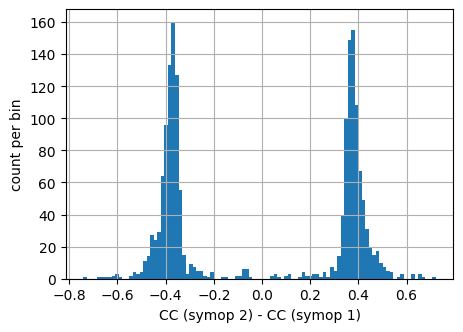

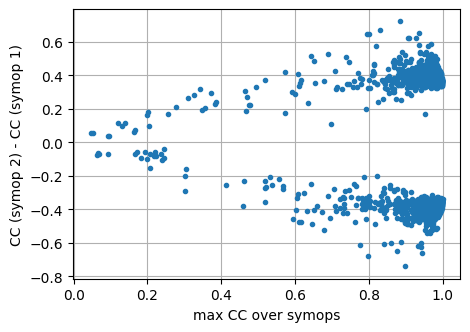

In [25]:
# If reindexing is relevant, it is good to check the gap in correlation coefficients with the reference across indexing solutions
# In the case of PTP-1B, any gap < 0.15 seems suspicious
if len(reindexing_record[0][2]) > 1:
    CC_dif=[x[2][1]-x[2][0] for x in reindexing_record]
    CC_max=[np.amax(x[2]) for x in reindexing_record]
    plt.figure(figsize=(5,3.5))
    plt.grid()
    plt.hist(CC_dif,100)
    plt.xlabel("CC (symop 2) - CC (symop 1)")
    plt.ylabel("count per bin")
    plt.show()
    
    plt.figure(figsize=(5,3.5))
    plt.grid()
    plt.plot(CC_max, CC_dif,'.')
    plt.ylabel("CC (symop 2) - CC (symop 1)")
    plt.xlabel("max CC over symops")
    plt.show()

#### Scaling Code
_Only need to run the following cell once, can skip on rerun._

In [26]:
file_list = glob.glob(reindexed_path + "*mtz")
file_list.sort()
print("We have " + str(len(file_list)) + " reindexed MTZ files.")

We have 1679 reindexed MTZ files.


The following optimization of scales sometimes generates numerical warnings about overflows. Let us know if this happens a lot.
It takes about 400 sec for the PTP1B data.

In [27]:
%%time
# Scales all datasets to the previously provided reference, writes a `metrics.pkl`
# Returns some metrics on the quality of the dataset.
if ncpu > 1:
    scaler = valdo.Scaler_pool(reference_mtz=file_list[0],columns=[amplitude_col, error_col],verbose=False, n_iter=5,ncpu=ncpu)
    metrics = scaler.batch_scaling(mtz_path_list=file_list, 
                                   outputmtz_path=scaled_path,
                                   prefix=run_prefix)
else:
    scaler = valdo.Scaler(reference_mtz=file_list[0])
    metrics = scaler.batch_scaling(mtz_path_list=file_list, 
                                   outputmtz_path=scaled_path,
                                   prefix=run_prefix, 
                                   verbose=False)

/n/home12/dhekstra/ipython_notebooks/drug-screening/valdo/scaling.py:191: RuntimeWarning: overflow encountered in exp
  FB_scaled = np.exp(ln_k) * np.exp(-args) * FB
/n/home12/dhekstra/ipython_notebooks/drug-screening/valdo/scaling.py:191: RuntimeWarning: invalid value encountered in multiply
  FB_scaled = np.exp(ln_k) * np.exp(-args) * FB
/n/home12/dhekstra/ipython_notebooks/drug-screening/valdo/scaling.py:191: RuntimeWarning: overflow encountered in exp
  FB_scaled = np.exp(ln_k) * np.exp(-args) * FB
/n/home12/dhekstra/ipython_notebooks/drug-screening/valdo/scaling.py:191: RuntimeWarning: invalid value encountered in multiply
  FB_scaled = np.exp(ln_k) * np.exp(-args) * FB
/n/home12/dhekstra/ipython_notebooks/drug-screening/valdo/scaling.py:191: RuntimeWarning: overflow encountered in exp
  FB_scaled = np.exp(ln_k) * np.exp(-args) * FB
/n/home12/dhekstra/ipython_notebooks/drug-screening/valdo/scaling.py:191: RuntimeWarning: invalid value encountered in multiply
  FB_scaled = np.exp(l

CPU times: user 1.09 s, sys: 405 ms, total: 1.5 s
Wall time: 17.6 s


In [28]:
metrics.head(10)

,file,start_LS,start_corr,end_LS,end_corr
0,0001,0.000e+00,1.000,0.000e+00,1.000
1,0002,3.338e+06,0.955,1.198e+06,0.955
2,0004,6.935e+06,0.873,4.336e+06,0.873
3,0006,1.879e+06,0.996,9.389e+04,0.996
4,0009,2.359e+05,0.998,5.738e+04,0.998
5,0010,3.397e+06,0.974,7.941e+05,0.974
6,0011,3.485e+06,0.998,5.354e+04,0.998
7,0012,2.436e+06,0.992,2.046e+05,0.992
8,0013,1.582e+06,0.997,1.658e+05,0.997
9,0014,1.575e+06,0.979,7.386e+05,0.979


### Step 3: Normalization & Preparation of VAE input

This step involves normalizing the scaled structure factor amplitudes obtained in the previous step. The input is restricted to only those Miller indices present in the intersection of all datasets, and the VAE predicts structure factor amplitudes for all Miller indices in the union of all datasets.

Additionally, we standardize all the input data, such that the structure factor amplitudes for each Miller index in the union of all datasets have a mean of zero and a unit variance across datasets. 

#### Usage

1. Import the required library, `valdo.preprocessing`.

2. Find the intersection and union of the scaled datasets using the following functions:

   - `find_intersection()`: Finds the intersection of `amplitude_col` from multiple input MTZ files and saves the result to the specified output pickle file. Arguments include the following:

      - `input_files`: List of input MTZ file paths.
      - `output_path`: Path to save the output pickle file containing the intersection data.
      - `amplitude_col`: Name of the column in the dataset that represents the scaled amplitude (default is 'F-obs-scaled').

   - `find_union()`: Finds the union of `amplitude_col` from multiple input MTZ files and saves the result to the specified output pickle file. Arguments are the same as `find_intersection()`.

3. Generate the VAE input and output data using the `generate_vae_io()` function. This standardizes the intersection dataset using mean and standard deviation calculated from the union dataset. The standardized intersection becomes the VAE input, while the standardized union becomes the VAE output. Both the VAE input and output are saved to the specified folder. 

    This function can be called with the following parameters:

    - `intersection_path`: Path to the intersection dataset pickle file.
    - `union_path`: Path to the union dataset pickle file.
    - `io_path`: Path to the output folder where the VAE input and output will be saved. Mean and standard deviation data calculated from the union dataset will also be saved in this folder as `union_mean.pkl` and `union_sd.pkl`.

#### Code
_Only need to run this code once, can skip on rerun._

In this example, we remove samples with low `end_corr`. This ensures that our VAE is trained with high quality samples.

In [29]:
# Identify all scaled files to use as input and output for the VAE

file_list = glob.glob(scaled_path + "*mtz")
file_list.sort()
print("Current file list contains " + str(len(file_list)) + " entries.")

Current file list contains 1679 entries.


This following cell removes samples with `end_corr < min_cc_ref` or if `end_corr = NA`.

In [30]:
metrics_df = pd.read_pickle(scaled_path + "metrics.pkl")
# moved formatting into scaling fcn
metrics_df[metrics_df.isna().any(axis=1)]
low_corr_files = list(metrics_df[(metrics_df['end_corr'] < min_cc_ref) | (metrics_df['end_corr'].isnull())]['file'])
low_corr_files = [scaled_path + x + '.mtz' for x in low_corr_files]
file_list = [file for file in file_list if file not in low_corr_files]

with open(os.path.join(vae_path, 'filtered_file_list.pkl'), 'wb') as f:
    pickle.dump(file_list, f)
print("The file list contains " + str(len(file_list)) + " entries after filtering.")

The file list contains 1611 entries after filtering.


For testing purposes, we will subsample the list of entries.

In [31]:
if fraction < fraction:
    file_list = sample(file_list, int(fraction * len(file_list)))
print("Subsampling " + str(len(file_list)) + " entries.")

Subsampling 1611 entries.


The following cells generate the VAE input and output. The first cell takes about 3 min for PTP1B; the second one about 10 min (both on a CPU).

In [14]:
%%time
# Creates an `intersection.pkl` file at the specified path
# This is the intersection of all the scaled files provided

valdo.preprocessing.find_intersection(input_files=file_list, 
                  output_path=intersection_path,
                  amplitude_col=amplitude_scaled_col)

100%|███████████████████████████████████████| 1611/1611 [00:41<00:00, 38.55it/s]


CPU times: user 1min 37s, sys: 3.56 s, total: 1min 41s
Wall time: 1min 48s


In [15]:
%%time
# Creates a `union.mtz` file at the specified path
# This is the union of all the scaled files provided
# This is a lot slower than the intersection step about. The step is 
#   about linear in the number of files, 0.5 sec/file on my CPU (0.3 sec/file on GPU).
# Inclusion of errors does not affect speed -- *always include them*

valdo.preprocessing.find_union(input_files=file_list, 
                               output_path=union_path,
                               sigF_path=sigF_path,
                               amplitude_col=amplitude_scaled_col, 
                               include_errors=True)

Done reading in 1611 files (disregarding errors); now starting concatenation. Please be patient.
CPU times: user 6min 10s, sys: 10.4 s, total: 6min 20s
Wall time: 6min 23s


In [16]:
%%time
# Generates VAE input and output data from the intersection and union datasets
# Inclusion of errors does not affect speed => always include them here.
# Note that we do not currently prefix the VAE input
valdo.preprocessing.generate_vae_io(intersection_path=intersection_path, 
                                    union_path=union_path, 
                                    sigF_path=sigF_path,
                                    io_folder=vae_path, 
                                    prefix="", 
                                    include_errors=True)

(1611, 77821)
(77821,)
(77821,)
(1611, 2796)
(1611, 77821)
Created starting files for VAE in /n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline/vae/ with prefix = 
CPU times: user 1min 10s, sys: 5.81 s, total: 1min 16s
Wall time: 1min 16s


### Step 4: VAE Training

In this step, we train the VAE model using the provided VAE class.

#### Usage

1. Load the VAE input and output data that was generated in the previous step.

2. Initialize the VAE model with the desired hyperparameters. Tune-able hyperparameters include the following:
    - `n_dim_latent`: Number of dimensionality in latent space (optional, default `1`)

    - `n_hidden_layers`: Number of hidden layers in the encoder and decoder. If an int is given, it will applied to both encoder and decoder; If a length 2 list is given, first int will be used for encoder, the second will be used for decoder

    - `n_hidden_size`: Number of units in hidden layers. If an int is given, it will be applied to all hidden layers in both encoder and decoder; otherwise, an array with length equal to the number of hidden layers can be given, the number of units will be assigned accordingly.

    - `activation` : Activation function for the hidden layers (optional, default `tanh`)

3. Split the data into training and validation sets. Randomly select a subset of indices for training and use the rest for validation.

4. Convert the data into PyTorch tensors.

5. Set up the optimizer for training.

6. Train the VAE model using the `train()` method. The training process involves minimizing the ELBO (Evidence Lower Bound) loss function, which consists of a Negative Log-Likelihood (NLL) term and a Kullback-Leibler (KL) divergence term. Arguments used in this function include:

    - `x_train`: Input data for training the VAE, a PyTorch tensor representing the VAE input data. 

    - `y_train`: Output data for training the VAE, a PyTorch tensor representing the VAE output data. 

    - `optim`: The optimizer used for training the VAE, a PyTorch optimizer object, such as `torch.optim.Adam`, that specifies the optimization algorithm and its hyperparameters, including the learning rate (`lr`).

    - `x_val`: Input data for validation during training. (optional, default is `None`).

    - `y_val`: Output data for validation during training. (optional, default is `None`).

    - `epochs`: The number of training epochs (epoch: a single pass through the data).

    - `batch_size`: The batch size used during training. If an integer is provided, the same batch size will be used for all epochs. If a list of integers is provided, it should have the same length as the number of epochs, and each value in the list will be used as the batch size for the corresponding epoch. Default is `256`.

    - `w_kl`: The weight of the Kullback-Leibler (KL) divergence term in the ELBO loss function. The KL divergence term encourages the latent distribution to be close to a prior distribution (usually a standard normal distribution). A higher value of `w_kl` will increase the regularization strength on the latent space. Default is `1.0`.

    **Note:** The VAE class internally keeps track of the training loss (`loss_train`) and its components (NLL and KL divergence) during each batch of training. These values can be accessed after training to monitor the training progress and performance. The `loss_train` attribute of the VAE object will be a list containing the training loss values for each batch during training. The `loss_names` attribute contains the names of the loss components: "Loss", "NLL", and "KL_div". These attributes are updated during training and can be used for analysis or visualization.

7. Save the trained VAE model for future use (optional).

#### Code

In [32]:
# Load the VAE I/O Files Generated
# note that we do not use a prefix since these files are likely to change less frequently than the runs.
vae_input  = np.load(vae_path + 'vae_input.npy')
vae_output = np.load(vae_path + 'vae_output.npy')
vae_sigF   = np.load(vae_path + 'vae_sigF.npy')

In [33]:
print(vae_input.shape)
print(vae_output.shape)
print(vae_sigF.shape)

(1611, 2796)
(1611, 77821)
(1611, 77821)


In [34]:
union = pd.read_pickle(union_path)
union.iloc[:5,:20]

F_0001.mtz  F_0002.mtz  F_0004.mtz  F_0006.mtz  F_0009.mtz  \
H K L                                                                
0 0 6        134.2   202.34412   277.66992         NaN    142.1195   
    9        84.87    86.05814    107.6388         NaN    79.71563   
    12        55.4    74.71822    96.31223         NaN   61.552193   
    15       71.83    89.88488   117.58291         NaN    67.42455   
    18       71.04    87.75839    121.0765    73.29946    69.20358   

        F_0010.mtz  F_0011.mtz  F_0012.mtz  F_0013.mtz  F_0014.mtz  \
H K L                                                                
0 0 6    167.11179         NaN   152.84111   175.45123   186.25133   
    9    109.54938         NaN    91.42984    97.61132    99.41929   
    12   61.761147         NaN    58.21221    64.51231   73.786964   
    15    70.45288    71.83424    63.73514    81.44395    86.50656   
    18    84.86576    74.28783    76.02929     79.0467    88.27989   

        F_0015.mtz  F_0017.mtz  F_0018.mtz  F_0019.mtz  F_0020.mtz  \
H K L                                                                
0 0 6    226.77435   167.08795   159.99818   184.05544   221.49411   
    9   110.586136    78.16577    76.01287   86.014626   94.724464   
    12   85.069275    62.87241    58.30149   67.985214    80.60507   
    15   106.25036   72.626045    70.30398    78.45188    98.24211   
    18   106.99872    73.06774    72.02638    84.94232   101.57818   

        F_0021.mtz  F_0022.mtz  F_0023.mtz  F_0024.mtz  F_0025.mtz  
H K L                                                               
0 0 6    221.99393   244.62155         NaN         NaN   216.60344  
    9   102.495094   100.71551     98.0721         NaN    90.96382  
    12    83.96858    86.86581    76.12774         NaN    79.18713  
    15  102.449295    103.2815    90.82293         NaN    92.86111  
    18  102.028404   102.24076   96.991844         NaN    89.06635

In [35]:
sigF = pd.read_pickle(sigF_path)
sigF.iloc[:5,:20]

SIGF_0001.mtz  SIGF_0002.mtz  SIGF_0004.mtz  SIGF_0006.mtz  \
H K L                                                                
0 0 6           2.383      3.5082433      6.9472537            NaN   
    9           1.503      1.4892293      2.7093766            NaN   
    12         0.9909      1.2982225      2.4589353            NaN   
    15          1.283      1.5631075      4.2917604            NaN   
    18          1.271      2.1704834      3.1036866      1.5473843   

        SIGF_0009.mtz  SIGF_0010.mtz  SIGF_0011.mtz  SIGF_0012.mtz  \
H K L                                                                
0 0 6       2.4789047       1.789213            NaN      2.7834682   
    9       1.3840808      1.1858987            NaN      1.6600913   
    12      1.0712417     0.70691574            NaN      1.0598648   
    15      1.1755908      0.8030015      1.2124603      1.1623667   
    18      1.2072421      0.9553817      1.7803646      1.3865634   

        SIGF_0013.mtz  SIGF_0014.mtz  SIGF_0015.mtz  SIGF_0017.mtz  \
H K L                                                                
0 0 6       2.0206628      2.2634194      2.3444862      2.4469302   
    9       1.1249464      1.2087137      1.1695577       1.150906   
    12     0.75098336       0.904767      0.9333829      0.9393478   
    15      0.9461652      1.0595057      1.1528682      1.0846328   
    18      0.9208488      1.0836301      1.1712878      1.0946568   

        SIGF_0018.mtz  SIGF_0019.mtz  SIGF_0020.mtz  SIGF_0021.mtz  \
H K L                                                                
0 0 6       2.2613962      3.0893557       4.301191       4.485317   
    9       1.0795727      1.4595003      1.8397499      2.0672343   
    12      0.8377527      1.1764873      1.5776626       1.698578   
    15      1.4299301      1.9278698      1.9249655       2.081777   
    18      1.0357312      1.4750882      2.8421588      2.0696118   

        SIGF_0022.mtz  SIGF_0023.mtz  SIGF_0024.mtz  SIGF_0025.mtz  
H K L                                                               
0 0 6       2.9548802            NaN            NaN      3.7314587  
    9       1.2448399      1.1934857            NaN      1.5835252  
    12      1.0984814      0.9371079            NaN       1.400114  
    15      1.3021747      1.1172615            NaN      1.6406626  
    18      1.3030957      1.1936853            NaN      2.2506483

[0.017757078622902215 0.01733800511755529 0.025019828064771536 nan
 0.017442396046186234 0.010706683149896848 nan 0.01821151549004427
 0.011516948334077206 0.012152500709272616 0.010338409988935454
 0.014644563810537744 0.01413388646197214 0.0167849197397303
 0.019418985231855024 0.020204684383934284 0.012079394555774444 nan nan
 0.017227144109366162]


/tmp/ipykernel_2125321/75453041.py:3: RuntimeWarning: invalid value encountered in greater
  plt.hist(tmp[tmp>0],500)


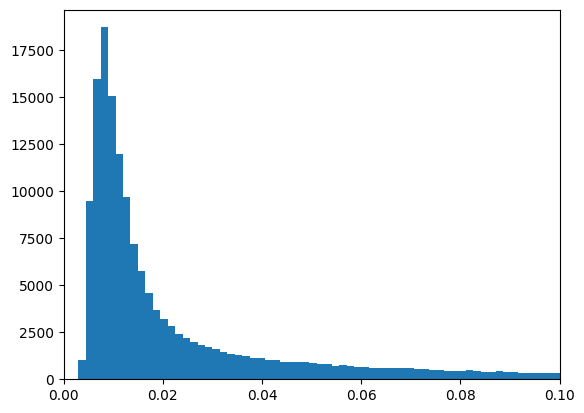

In [36]:
tmp=sigF.iloc[:500,:500].values.flatten()/union.iloc[:500,:500].values.flatten()
print(tmp[:20])
plt.hist(tmp[tmp>0],500)
plt.xlim([0,0.1])
plt.show()

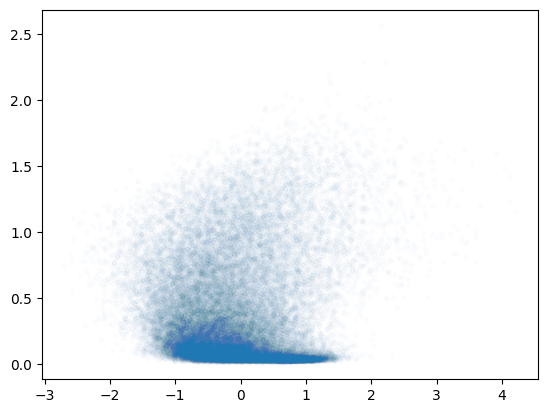

In [37]:
plt.plot(vae_output[10,:],vae_sigF[10,:],'.',alpha=0.01)
plt.show()

In [38]:
%%time
# Specify VAE Parameters; takes ~1 sec
# Only execute once. Otherwise it may throw an error.Restart kernel if this cell throws an error
latent_dimension = latent_dim
train_fraction = train_fraction
epochs = epochs # default: 300

vae = valdo.VAE(n_dim_i = vae_input.shape[1], 
      n_dim_o = vae_output.shape[1], 
      n_dim_latent = latent_dimension, 
      n_hidden_layers = [3, 6], 
      n_hidden_size = 100, 
      activation = torch.relu)

# Randomly select (train_fraction) indices for training
choice = np.random.choice(vae_input.shape[0], int(train_fraction*vae_input.shape[0]), replace=False)    
train_ind = np.zeros(vae_input.shape[0], dtype=bool)
train_ind[choice] = True
test_ind = ~train_ind
print("Size of training set = " + str(np.sum(train_ind)))
print("Size of test set = " + str(np.sum(test_ind)))

# Split the input and output data into training and validation sets
x_train, x_val = vae_input[train_ind], vae_input[test_ind]
y_train, y_val = vae_output[train_ind], vae_output[test_ind]
e_train, e_val = vae_sigF[train_ind], vae_sigF[test_ind] # error estimates for y

# Convert the data to torch tensors
x_train, x_val, y_train, y_val, e_train, e_val = torch.tensor(x_train), torch.tensor(x_val), \
                                                 torch.tensor(y_train), torch.tensor(y_val), \
                                                 torch.tensor(e_train), torch.tensor(e_val)

Size of training set = 1288
Size of test set = 323
CPU times: user 1.02 s, sys: 415 ms, total: 1.43 s
Wall time: 1.45 s


In [39]:
%%time
# Set up the optimizer and train the VAE
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
vae.train(x_train, y_train, e_train, optimizer, x_val, y_val, e_val, epochs=epochs, 
          batch_size=100, w_kl=1.0,
          eps=0.05,
          include_errors=include_errors,
          stdof=stdof, 
          verbose=True)


Ep 1: 100%|█| 13/13 [00:01<00:00,  9.54it/s, Test=8.57e+6, Train=8.33e+6, mem=0.
Ep 2: 100%|█| 13/13 [00:01<00:00, 11.23it/s, Test=8.15e+6, Train=8.53e+6, mem=0.
Ep 3: 100%|█| 13/13 [00:01<00:00, 11.30it/s, Test=7.97e+6, Train=8.47e+6, mem=0.
Ep 4: 100%|█| 13/13 [00:01<00:00, 11.16it/s, Test=7.46e+6, Train=8.12e+6, mem=0.
Ep 5: 100%|█| 13/13 [00:01<00:00, 11.31it/s, Test=7.32e+6, Train=7.3e+6, mem=0.6
Ep 6: 100%|█| 13/13 [00:01<00:00, 11.20it/s, Test=7.35e+6, Train=7.28e+6, mem=0.
Ep 7: 100%|█| 13/13 [00:01<00:00, 11.28it/s, Test=7.11e+6, Train=7.1e+6, mem=0.6
Ep 8: 100%|█| 13/13 [00:01<00:00, 11.34it/s, Test=6.88e+6, Train=7.09e+6, mem=0.
Ep 9: 100%|█| 13/13 [00:01<00:00, 11.25it/s, Test=6.58e+6, Train=6.37e+6, mem=0.
Ep 10: 100%|█| 13/13 [00:01<00:00, 11.43it/s, Test=6.45e+6, Train=6.13e+6, mem=0
Ep 11: 100%|█| 13/13 [00:01<00:00, 11.36it/s, Test=6.16e+6, Train=6.09e+6, mem=0
Ep 12: 100%|█| 13/13 [00:01<00:00, 11.30it/s, Test=6.22e+6, Train=6.11e+6, mem=0
Ep 13: 100%|█| 13/13 [00:01<

CPU times: user 1min 28s, sys: 27.6 s, total: 1min 56s
Wall time: 1min 56s


In [40]:
# Save the trained VAE model
vae.save(vae_path + run_prefix + 'trained_vae.pkl')
# vae.save(vae_path + 'trained_vae_student_t.pkl')

##### Check on memory usage:

In [44]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                     file_list: 14.0 KiB
                        CC_dif: 14.0 KiB
                        CC_max: 14.0 KiB
             reindexing_record: 13.2 KiB
                             _:  9.6 KiB
                            __:  9.6 KiB
                           _34:  9.6 KiB
                           _35:  9.6 KiB
                          tqdm:  2.0 KiB
                     train_ind:  1.7 KiB


In [45]:
try:
    del metrics, metrics_df
    del union, sigF
    del tmp
except Exception as e:
    print(e)

name 'metrics' is not defined


##### Visualization of loss traces

The following cells allow us to visualize the loss over epochs.

In [46]:
# Plot the loss over time

vae = valdo.VAE.load(vae_path + run_prefix + 'trained_vae.pkl')
loss_array = np.array(vae.loss_train)

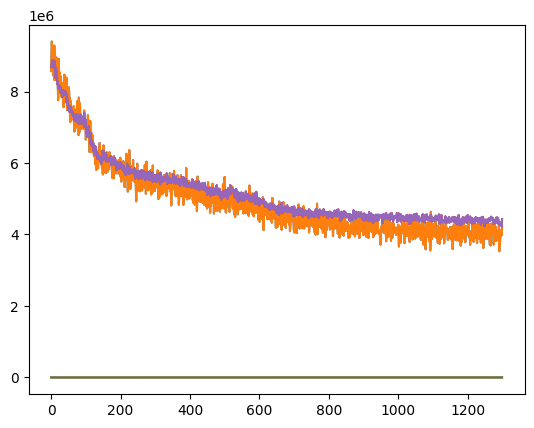

In [47]:
plt.plot(loss_array)
plt.show()

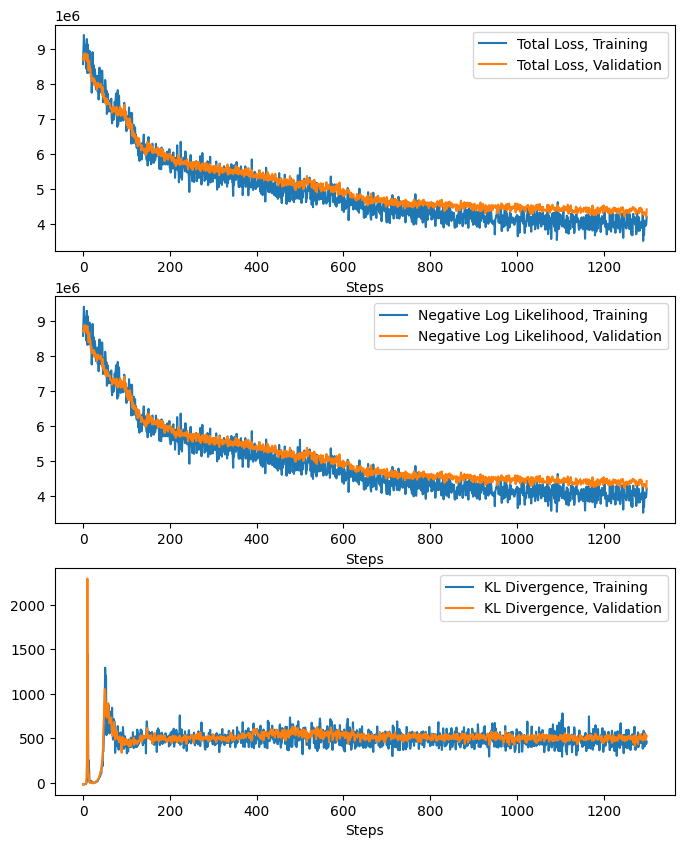

In [48]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=[8,10])
ax = axs.reshape(-1)

ax[0].plot(loss_array[:,0], label='Total Loss, Training')
ax[0].plot(loss_array[:,3], label='Total Loss, Validation')
ax[0].set_xlabel("Steps")
ax[0].legend()

ax[1].plot(loss_array[:,1], label='Negative Log Likelihood, Training')
ax[1].plot(loss_array[:,4], label='Negative Log Likelihood, Validation')
ax[1].set_xlabel("Steps")
ax[1].legend()

ax[2].plot(loss_array[:,2], label='KL Divergence, Training')
ax[2].plot(loss_array[:,5], label='KL Divergence, Validation')
ax[2].set_xlabel("Steps")
ax[2].legend()

plt.show()

### Steps 5 & 6: Reconstruction of "Apo" Data & Calculating Difference Maps

In this step, VAE outputs are re-scaled accordingly to recover the original scale, and differences in amplitudes between the original and reconstructed data are calculated. A `recons` and a `diff` column will be created for all datasets.

#### Usage

To perform the reconstruction, or re-scaling, the `rescale()` function can be called, providing the necessary arguments:

- `recons_path`: Path to the reconstructed output of the VAE in NumPy format.
- `intersection_path`: Path to the pickle file containing the intersection of all scaled datasets.
- `union_path`: Path to the pickle file containing the union data of all scaled datasets.
- `input_files`: List of input file paths. This list should be in the same order as is in the `vae_input.npy` or `intersection.mtz`.
- `info_path`: Path to the folder containing files with the mean and SD used for standardization previously.
- `output_path`: Path to the folder where the reconstructed data will be saved.
- `amplitude_col`: Column in the MTZ file that contains structure factor amplitudes to calculate the difference column.

#### Code
_Loads its inputs, saves its outputs._

In [55]:
# Load trained VAE
# vae = valdo.VAE.load(vae_path + run_prefix + 'trained_vae.pkl')
vae = valdo.VAE.load(vae_path + run_prefix + 'trained_vae.pkl')

In [56]:
# Load input file and create a tensor

# vae_input = np.load(vae_path + run_prefix + 'vae_input.npy')
vae_input = np.load(vae_path + 'vae_input.npy')
vae_input_tensor = torch.tensor(vae_input)
if bGPU:
    vae_input_tensor = vae_input_tensor.to("cuda:0")

In [57]:
# Reconstruct the input file via VAE, convert to numpy, and save

recons = vae.reconstruct(torch.tensor(vae_input_tensor))
recons = recons.detach().cpu().numpy()
np.save(vae_reconstructed_path + 'recons', recons)

/tmp/ipykernel_2126956/2025911098.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recons = vae.reconstruct(torch.tensor(vae_input_tensor))


The following takes about 5 min for 1600 files (abt 5 files/sec; should be linear in time)

Possibly, this step can crash the kernel/session if not enough memory is available. In that case, try reducing ncpu below the available number of CPUs.

In [58]:
%%time
# Re-scale the reconstructed files accordingly and creates the `diff` column
# Function is valdo.preprocessing.rescale

with open(os.path.join(vae_path, 'filtered_file_list.pkl'),'rb') as f:
    file_list = pickle.load(f)

print(len(file_list))

if ncpu > 1:
    valdo.preprocessing.rescale_pool(recons_path=vae_reconstructed_path + 'recons.npy', 
                intersection_path=intersection_path, 
                union_path=union_path, 
                input_files=file_list, 
                info_folder=vae_path, 
                output_folder=vae_reconstructed_path,
                amplitude_col="F-obs-scaled",
                ncpu=ncpu)
else:
    valdo.preprocessing.rescale(recons_path=vae_reconstructed_path + 'recons.npy', 
                intersection_path=intersection_path, 
                union_path=union_path, 
                input_files=file_list, 
                info_folder=vae_path, 
                output_folder=vae_reconstructed_path,
                amplitude_col="F-obs-scaled")

1611
Done rescaling.
CPU times: user 32.3 s, sys: 59.4 s, total: 1min 31s
Wall time: 2min 11s


### Steps 7 & 8: Gaussian Blurring & Searching for Blobs

**Note Regarding Phases:** In this section, phases are required for each dataset. You can obtain phases by completing refinement via PHENIX for each dataset, and utilizing those phases.

**Note Regarding Models:** In this section, models are also required for each dataset. These can also be obtained by refinement via PHENIX for each dataset, and they should be stored in a single folder, with the same naming convention (i.e. ##.mtz).

We offer a command-line tool for automatic refinement using PHENIX. Based on our tests, starting with a single apo model yields satisfactory phases and models for the following real-space maps. You can find an example refine_drug.eff file in the notebook/ directory.

*Code Example:* `valdo.refine --pdbpath "xxx/xxx_apo.pdb" --mtzpath "xxx/*.mtz" --output "yyy/" --eff "xxx/refine_drug.eff"`

In this step, we aim to identify significant changes in electron density caused by ligand binding to a protein. By taking the absolute value of the electron density difference maps and applying Gaussian blurring, a new map is created with merged positive electron density blobs. The blurring process attempts to reduce noise. Blobs are then identified and characterized above a specified contour level and volume threshold.

#### Usage

To generate blobs from electron density maps, call the `generate_blobs()` function, which takes electron density map files and corresponding refined protein models as inputs. The function preprocesses the maps and identifies blobs above a specified contour level and volume threshold (the volume threshold is the default set by `gemmi`). The output is a DataFrame containing statistics for each identified blob, including peak value, score, centroid coordinates, volume, and radius. 

This function can be called with the following arguments:

- `input_files`: List of input file paths.
- `model_path`: Path to the folder containing the refined models for each dataset (pdb format).
- `diff_col`: Name of the column representing diffraction values in the input MTZ files.
- `phase_col`: Name of the column representing phase values in the input MTZ files.
- `output_path`: Path to the output folder where the blob statistics DataFrame will be saved.
- `cutoff`: Blob cutoff value. Blobs with values below this cutoff will be ignored (optional, default is `5`).
- `negate`: Whether to negate the blob statistics (optional, default is `False`). Use True if there is interest in both positive and negative peaks, which is not typically of interest here due to the absolute value function applied to the map.
- `sample_rate`: Sample rate for generating the grid in the FFT process (optional, default is `3`).

#### Code

The following cell **adds phases** to our newly reconstructed datasets. These phases are copied from `../../pipeline/data/refined_mtzs/` which were generated via PHENIX.

In [15]:
print(refined_apo_mtzs_path)
print(vae_reconstructed_with_phases_path)

/n/holyscratch01/hekstra_lab/phyllis/pipeline/data/refined_mtzs/
/n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline/vae/reconstructed_w_phases/


Timing estimate: The following proceeds at about 8 files/second on a single GPU.

In [124]:
%%time
# List of reconstructed mtz files without phases to add phases to

file_list = glob.glob(vae_reconstructed_path + "*.mtz")
file_list_w_phases = file_list.copy()
print("Working with " + str(len(file_list)) + " MTZs containing reconstructed (apo-like) amplitudes.")

if ncpu > 1:
    results = valdo.helper.add_phases_pool(file_list, 
                                           refined_apo_mtzs_path, 
                                           vae_reconstructed_with_phases_path, 
                                           phase_2FOFC_col_out=phase_2FOFC_col, phase_FOFC_col_out=phase_FOFC_col,
                                           phase_2FOFC_col_in ='PH2FOFCWT', phase_FOFC_col_in ='PHFOFCWT',
                                           prefix=run_prefix, 
                                           ncpu=ncpu)
    print(results.head())
else:
    no_phases_files = valdo.helper.add_phases(file_list, refined_apo_mtzs_path, vae_reconstructed_with_phases_path, 
                              phase_2FOFC_col_out=phase_2FOFC_col, phase_FOFC_col_out=phase_FOFC_col,
                              phase_2FOFC_col_in ='PH2FOFCWT', phase_FOFC_col_in ='PHFOFCWT')
    print("Done. No phases found for " + str(len(no_phases_files)) + " starting MTZs.")

Working with 1612 MTZs containing reconstructed (apo-like) amplitudes.
                                                file  success
0  /n/holyscratch01/hekstra_lab/dhekstra/valdo-te...     True
1  /n/holyscratch01/hekstra_lab/dhekstra/valdo-te...     True
2  /n/holyscratch01/hekstra_lab/dhekstra/valdo-te...     True
3  /n/holyscratch01/hekstra_lab/dhekstra/valdo-te...     True
4  /n/holyscratch01/hekstra_lab/dhekstra/valdo-te...    False
CPU times: user 271 ms, sys: 1.11 s, total: 1.39 s
Wall time: 7.59 s


In [ ]:
# ds=rs.read_mtz(vae_reconstructed_with_phases_path + 'run2_1157.mtz')
# ds.iloc[120:130,:]

In [ ]:
# Some checks
# print(str(len(no_phases_files)))
# print(str(len(file_list_w_phases)))

The following two cells complete gaussian blurring and blob searching. For the blurring, the radius is set to `5A` with `sigma = 5/3`.

In [125]:
# List of reconstructed mtz files (with phases) to identify blobs in
# tmp="/n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline_run2/vae/reconstructed_w_phases/"

# usually vae_reconstructed_with_phases_path rather than tmp
file_list = glob.glob(vae_reconstructed_with_phases_path + "*mtz")
print("Retrieving " + str(len(file_list)) + " files for blob analysis.")

Retrieving 1572 files for blob analysis.


The following takes about 0.3 s/dataset on a single CPU for PTP1B and will scale with the number of voxels.

In [150]:
%%time
# Function in valdo.blobs that generates a list of blobs

if ncpu>1:
    valdo.blobs.generate_blobs_pool(input_files=file_list, 
                   model_folder=refined_apo_pdbs_path, 
                   diff_col='diff', 
                   phase_col='refine_PH2FOFCWT', 
                   output_folder=blob_path, 
                   prefix=run_prefix,
                   cutoff=blob_sig_cutoff,
                   radius_in_A=radius_in_A,
                   ncpu=ncpu)
else:
    valdo.blobs.generate_blobs(input_files=file_list, 
                   model_folder=refined_apo_pdbs_path, 
                   diff_col='diff', 
                   phase_col='refine_PH2FOFCWT', 
                   output_folder=blob_path, 
                   prefix=run_prefix,
                   cutoff=blob_sig_cutoff,
                   radius_in_A=radius_in_A)

Done generating blobs with starmap/pool and wrote /n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline/vae/blobs/run_9_11231_blob_stats.pkl
CPU times: user 1.18 s, sys: 853 ms, total: 2.04 s
Wall time: 14.6 s


### Step 9: Identifying Events

In this final step, the highest scoring blobs returned in the previous step can be analyzed individually. If the blob is plausibly a ligand, refinement with a ligand may be completed to determine whether or not the blob can be considered a "hit."

Blobs that are returned can be related to various other events, not just ligand binding. Examples may include ligand-induced conformational change (which would still indicate the presence of a ligand) or various other unrelated conformational changes, such as radiation damage or cysteine oxidation (as is seen in `pipeline.ipynb`).

In the following example, we have also included the evaluation of our method, via AUC, in this section.

#### Helper Functions

These functions will help us do various tasks. 

For example, we may want to remove blobs that are associated with `cys215` oxidation, as in PTP1B, the oxidation of `cys215` modulates the protein's activity.

Additionally, to evaluate our method, we have a function that tags each blob to identify whether or not it is a blob associated with a ligand. We can then calculate the AUC. 

Various other helpful functions are also included.

##### `find_nearby_atoms`

In [19]:
def find_nearby_atoms(centroid_dict, structure_path, sample_no=None, radius=3):
    
    """
    Finds nearby atoms within a specified radius around a given centroid position in a structure file and returns the atom details as a DataFrame.

    The function reads the structure file in PDB format using gemmi, performs a neighbor search within the specified radius around the centroid position, and retrieves information about the nearby atoms. The atom details include the sample number, chain name, residue sequence ID, residue name, atom name, element name, coordinates (x, y, z), and distance from the centroid.

    Args:
        centroid_dict (dict): Dictionary containing the centroid position with keys 'x', 'y', and 'z'.
        structure_path (str): Path to the structure file in PDB format.
        sample_no (str): Sample number or identifier. Optional.
        radius (float, optional): Radius in angstroms to search for nearby atoms. Default is 3.

    Returns:
        pandas.DataFrame: DataFrame containing the details of the nearby atoms.

    Example:
        centroid = {'x': 10.0, 'y': 20.0, 'z': 30.0}
        structure_file = './data/structure.pdb'
        sample_number = 'S001'
        nearby_atoms = find_nearby_atoms(centroid, structure_file, sample_number, radius=5)
    """
    
    peaks = []
    
    structure = gemmi.read_pdb(structure_path)
    ns = gemmi.NeighborSearch(structure[0], structure.cell, radius).populate()
    centroid = gemmi.Position(centroid_dict["x"], centroid_dict["y"], centroid_dict["z"])
    marks = ns.find_atoms(centroid)
    
    for mark in marks:
        image_idx = mark.image_idx
        cra = mark.to_cra(structure[0])
        dist = structure.cell.find_nearest_pbc_image(centroid, cra.atom.pos, mark.image_idx).dist()

        record = {
            "sample"  :    sample_no,
            "chain"   :    cra.chain.name,
            "seqid"   :    cra.residue.seqid.num,
            "residue" :    cra.residue.name,
            "atom"    :    cra.atom.name,
            "element" :    cra.atom.element.name,
            "coordx"  :    cra.atom.pos.x,
            "coordy"  :    cra.atom.pos.y,
            "coordz"  :    cra.atom.pos.z,
            "dist"    :    dist
        }

        peaks.append(record)
        
    return pd.DataFrame(peaks)

##### Tag Blobs near Cys215 (`tag_cys_215_blobs`)

In [20]:
def check_blob_for_cys(row, additional_args):
    """
    Args:
        row (pandas.Series): A row of the DataFrame representing a blob.

    Returns:
        int: Returns 1 if the blob contains CYS 215, otherwise returns 0.
    """
    
    structure_path=additional_args[0]
    radius=additional_args[1]
    sample = row["sample"]
    
    cenx, ceny, cenz = row['cenx'], row['ceny'], row['cenz']
    atoms_df = find_nearby_atoms({"x": cenx, "y": ceny, "z": cenz}, structure_path + sample + '.pdb', sample, radius)

    row['cys215']=0
    if len(atoms_df) < 1:
        return row
    
    # if 215 in set(atoms_df['seqid']):
    #     return 1
    # return 0
    try:
        if 215 in set(atoms_df['seqid']):
            row['cys215']=1
    except Exception as e:
        print(e)
        print(atoms_df.info())
        raise
    
    return row

def tag_cys_215_blobs(df, structure_path, radius=3,ncpu=1):
    
    """
    Tags the blobs in the DataFrame 'df' that contain the CYS 215 residue based on the nearby atoms found in PDB files.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the blobs information.
        structure_path (str): The path to the folder containing the PDB files used for identifying nearby atoms.
        radius (int, optional): The radius in Angstroms for finding nearby atoms. Default is 3.

    Returns:
        pandas.DataFrame: The modified DataFrame with an additional 'cys215' column indicating the presence (1) or absence (0) of CYS 215 in the blobs.
    """
    
    
    df['cys215']=0
    additional_args=[structure_path,radius]
    if ncpu>1:
        with Pool(ncpu) as pool:
            result = pool.starmap(check_blob_for_cys, zip(df.to_dict('records'),repeat(additional_args)))
        
        # merge results back together
        # print(result)
        df_result = pd.DataFrame.from_records(result)
        df['cys215'] = df_result['cys215']
    else:
        # tqdm.pandas()
        try:
            df = df.apply(check_blob_for_cys, axis=1, args=(additional_args,))
        except Exception as e:
            print(e)
    
    return df

##### Tag Blobs near LIG Atoms

In [21]:
def check_blob_for_lig(row, additional_args):
    """
    Args:
        row (pandas.Series): A row of the DataFrame representing a blob.

    Returns:
        row (pandas.Series): with field 'ligand' added with value 1 if the blob contains ligands, otherwise 0.
    """
    structure_path=additional_args[0]
    sample = row["sample"]

    row['ligand'] = 0
    if row["bound"] == 0:
        return row
    
    cenx, ceny, cenz = row['cenx'], row['ceny'], row['cenz']
    atoms_df = find_nearby_atoms({"x": cenx, "y": ceny, "z": cenz}, structure_path + sample + '.pdb', sample, row['radius'])

    if len(atoms_df) < 1:
        return row
    
    if 'LIG' in set(atoms_df['residue']):
        # print(row)
        row['ligand']=1

    return row

    
def tag_lig_blobs(df, structure_path,ncpu=1):

    """
    Tags the blobs in the DataFrame 'df' that contain ligands based on the nearby atoms found in PDB files.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the blobs information.
        structure_path (str): The path to the folder containing the PDB files used for identifying nearby atoms.

    Returns:
        pandas.DataFrame: The modified DataFrame with an additional 'ligand' column indicating the presence (1) or absence (0) of ligands in the blobs.

    """

    # df['ligand']=0
    additional_args=[structure_path]
    if ncpu>1:
        with Pool(ncpu) as pool:
            result = pool.starmap(check_blob_for_lig, zip(df.to_dict('records'),repeat(additional_args)))
        
        # merge results back together
        df = pd.DataFrame.from_records(result)
    else:
        # tqdm.pandas()
        df = df.apply(check_blob_for_lig,args=(additional_args,), axis=1)
        # print(tmp.info())
        
    return df

##### Validate Fractional Coordinates

In [22]:
def valid_fractional_coords(coords):
    
    """
    Converts fractional coordinates to valid fractional coordinates within the range [0, 1).

    Args:
        coords (list or numpy.ndarray): The input fractional coordinates.

    Returns:
        numpy.ndarray: The converted valid fractional coordinates within the range [0, 1).

    """
    
    valid_coords = np.array(coords)
    for i in range(3):
        while valid_coords[i] > 1:
            valid_coords[i] -= 1
        while valid_coords[i] < 0:
            valid_coords[i] += 1
    return valid_coords

##### Determine Locations

In [23]:
# Function to fractionalize coordinates and find all symmetry-related cartesian points 

def apply_determine_locations(row, additional_args): 
    """
    Converts coordinates to fractional form and determines all symmetry-related cartesian points for the given row.

    Args:
        row (pandas.Series): A row of the DataFrame representing a blob.
        folder (str): The path to the folder containing the mtz files.

    Returns:
        pandas.Series: A pandas Series containing the fractional coordinates, all possible fractional coordinates, and all possible cartesian coordinates.

    """
    folder=additional_args[0]
    
    # find mtz file for sample number
    mtz_file = folder + row['sample'] + '.mtz'
    if mtz_file is None:
        return pd.Series({'fractional': np.nan, 'all_possible_frac': np.nan, 'all_possible_cart': np.nan})
    
    # read in mtz file
    sample_file = rs.read_mtz(mtz_file)
    
    # fractionalize coordinates using move2cell
    frac_coords = move2cell([row['cenx'], row['ceny'], row['cenz']], sample_file.cell)
    
    # identify all symmetry operations
    all_ops = list(sample_file.spacegroup.operations().sym_ops)

    all_possible_frac = []
    for op in all_ops:
        result = op.apply_to_xyz(frac_coords)
        result = valid_fractional_coords(result)
        all_possible_frac.append(result)
        
    all_possible_frac = sorted(all_possible_frac, key=lambda x: x[0])
                
    # orthogonalize fractional coordinates
    all_possible_cart = [sample_file.cell.orthogonalize(gemmi.Fractional(*elt)) for elt in all_possible_frac]
    
    all_possible_cart = [np.array([elt.x, elt.y, elt.z]) for elt in all_possible_cart]
    
    return pd.Series({'fractional': frac_coords, 'all_possible_frac': all_possible_frac, 'all_possible_cart': all_possible_cart})


def determine_locations(df, structure_path, ncpu=1):

    additional_args=[structure_path]
    if ncpu>1:
        with Pool(ncpu) as pool:
            additional_args=[structure_path]
            result = pool.starmap(apply_determine_locations, zip(df.to_dict('records'),repeat(additional_args)))
            result_df=pd.concat(result,axis=1).transpose()

        if not df.index.equals(result_df.index):
            # Should not happen, but let's be sure.
            print("Warning: apply_determine_locations returns a dataframe with different index than the input df.")
            
        df = pd.concat([df, result_df],axis=1,join='outer')
    else:
        # tqdm.pandas()
        df[['fractional', 'all_possible_frac', 'all_possible_cart']] = df.apply(apply_determine_locations, args=(additional_args,), axis=1)
    
    return df

##### Move Points to the Unit Cell

In [24]:
def move2cell(cartesian_coordinates, unit_cell, fractionalize=True):
    
    '''
    Move your points into a unitcell with translational vectors
    
    Parameters
    ----------
    cartesian_coordinates: array-like
        [N_points, 3], cartesian positions of points you want to move
        
    unit_cell, gemmi.UnitCell
        A gemmi unitcell instance
    
    fractionalize: boolean, default True
        If True, output coordinates will be fractional; Or will be cartesians
    
    Returns
    -------
    array-like, coordinates inside the unitcell
    '''
    o2f_matrix = np.array(unit_cell.fractionalization_matrix)
    frac_pos = np.dot(cartesian_coordinates, o2f_matrix.T) 
    frac_pos_incell = frac_pos % 1
    for i in range(len(frac_pos_incell)):
        if frac_pos_incell[i] < 0:
            frac_pos_incell[i] += 1
    if fractionalize:
        return frac_pos_incell
    else:
        f2o_matrix = np.array(unit_cell.orthogonalization_matrix)
        return np.dot(frac_pos_incell, f2o_matrix.T)

##### Remove Duplicate Blobs

In [25]:
def mark_duplicates(blobs_df):
    
    """
    Marks duplicate blobs in the DataFrame based on proximity in cartesian coordinates. 
    Checks on a per-sample basis, checking blobs with adjacent peak values.

    Args:
        blobs_df (pandas.DataFrame): The input DataFrame containing the blob information.

    Returns:
        pandas.DataFrame: The modified DataFrame with an additional 'duplicate' column indicating duplicate blobs.

    """
    
    blobs_df = blobs_df.sort_values(by='peak', ascending=False)
    blobs_df['duplicate'] = 0  # Initialize 'duplicate' column with 0
    
    def check_euclidean_distance(list1, list2, distance_cutoff=1):
        
        """
        Checks if the distance between any pairwise points in two lists is less than 1 A.

        Args:
            list1 (list): The first list of cartesian coordinates.
            list2 (list): The second list of cartesian coordinates.

        Returns:
            bool: Returns True if any distance is less than 1 A, otherwise returns False.

        """
        
        for point1 in list1:
            for point2 in list2:
                distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2 + (point2[2] - point1[2])**2)
                if distance < distance_cutoff:
                    return True
        return False
    
    grouped = blobs_df.groupby('sample')
    
    for _, group in grouped:
        if len(group) > 1:
            # print(group['all_possible_cart'])
            # all_possible_cart_lists = group['all_possible_cart'].tolist() # <<
            all_possible_cart_lists = group['all_possible_cart'].values.tolist() # works for ncpu=1 output
            for i in range(1, len(all_possible_cart_lists)):
                if check_euclidean_distance(all_possible_cart_lists[i-1], all_possible_cart_lists[i]):
                    blobs_df.at[group.index[i], 'duplicate'] = 1
    
    return blobs_df

#### Tagging Blobs

In this section, we tag and filter the blobs. We remove...

- blobs that are duplicates (we occassionally have duplicate blobs due to an issue with gemmi's ASU mask)
- blobs associated with the oxidation of `cys215`
- blobs that belong to low quality samples (high r factors in refinement)
- blobs that belong to samples with inconsistent data (in particular, Helen Ginn lists a few samples as hits without including a ligand in their bound state).

In [151]:
blob_df = pd.read_pickle(blob_path + run_prefix + 'blob_stats.pkl')
print(blob_df.describe())
blob_df.head(5)

           peakz       peak      score       cenx       ceny       cenz  \
count  12516.000  12516.000  12516.000  12516.000  12516.000  12516.000   
mean       7.652      7.652    158.101      3.934     43.371     15.972   
std        3.387      3.387    329.841     15.215     16.291     12.442   
min        4.439      4.439     42.434    -43.516     -3.287     -9.780   
25%        6.175      6.175     60.576     -6.646     35.716      4.524   
50%        6.949      6.949     81.140      1.990     45.272     14.791   
75%        8.046      8.046    131.794      9.803     53.049     27.691   
max       59.752     59.752   5813.113     48.156     79.567     46.700   

          volume     radius  
count  12516.000  12516.000  
mean      29.140      1.737  
std       49.279      0.505  
min       10.000      1.337  
25%       12.275      1.431  
50%       16.225      1.570  
75%       26.106      1.840  
max      991.511      6.186  


,sample,peakz,peak,score,cenx,ceny,cenz,volume,radius
0,1505,7.155,7.155,515.967,-1.745,52.084,33.745,105.399,2.930
1,1505,7.421,7.421,507.954,0.713,53.137,-1.366,102.487,2.903
2,1505,6.376,6.376,115.191,7.609,48.194,28.312,24.748,1.808
3,1505,5.986,5.986,103.712,40.097,7.187,7.642,22.710,1.757
4,1505,5.970,5.970,98.936,32.186,8.153,-0.542,21.546,1.726


Tag Samples that are Bound (1 if bound, 0 otherwise)

In [152]:
with open(bound_sample_ids) as f:
    bound_samples = set([line.strip() for line in f])

# Set the "bound" column based on whether or not each sample is in the bound samples list
blob_df["bound"] = blob_df["sample"].apply(lambda x: 1 if x in bound_samples else 0)

Tag Samples within 3A of a Cys215 Atom (1 if within, 0 otherwise)

In [153]:
%%time
#with one CPU, this takes about 40 sec
# sorry, tqdm.pandas interferes with passing additional arguments!

blob_df = tag_cys_215_blobs(blob_df, refined_apo_pdbs_path,ncpu=ncpu)

CPU times: user 492 ms, sys: 806 ms, total: 1.3 s
Wall time: 2.73 s


Tag Samples within `r` of a known LIG atom (1 if yes, 0 otherwise)

In [154]:
%%time
blob_df = tag_lig_blobs(blob_df, bound_models_standardized_path,ncpu=ncpu)
blob_df.describe()

CPU times: user 229 ms, sys: 724 ms, total: 953 ms
Wall time: 1.38 s


,peakz,peak,score,cenx,ceny,cenz,volume,radius,bound,cys215,ligand
count,12516.000,12516.000,12516.000,12516.000,12516.000,12516.000,12516.000,12516.000,12516.000,12516.000,12516.000
mean,7.652,7.652,158.101,3.934,43.371,15.972,29.140,1.737,0.121,0.066,0.019
std,3.387,3.387,329.841,15.215,16.291,12.442,49.279,0.505,0.326,0.248,0.135
min,4.439,4.439,42.434,-43.516,-3.287,-9.780,10.000,1.337,0.000,0.000,0.000
25%,6.175,6.175,60.576,-6.646,35.716,4.524,12.275,1.431,0.000,0.000,0.000
50%,6.949,6.949,81.140,1.990,45.272,14.791,16.225,1.570,0.000,0.000,0.000
75%,8.046,8.046,131.794,9.803,53.049,27.691,26.106,1.840,0.000,0.000,0.000
max,59.752,59.752,5813.113,48.156,79.567,46.700,991.511,6.186,1.000,1.000,1.000


Tag Blobs that are Duplicates of Other Blobs (Patch for Gemmi's ASU Mask Issue)

In [155]:
%%time
# Identifies all possible cartesian coordinates after symmetry operations
# blob_df[['fractional', 'all_possible_frac', 'all_possible_cart']] = blob_df.apply(determine_locations, args=(vae_reconstructed_with_phases_path,), axis=1)
blob_df = determine_locations(blob_df, vae_reconstructed_with_phases_path, ncpu=ncpu)

CPU times: user 2.84 s, sys: 960 ms, total: 3.8 s
Wall time: 17.9 s


In [156]:
blob_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12516 entries, 0 to 12515
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sample             12516 non-null  object 
 1   peakz              12516 non-null  float64
 2   peak               12516 non-null  float64
 3   score              12516 non-null  float64
 4   cenx               12516 non-null  float64
 5   ceny               12516 non-null  float64
 6   cenz               12516 non-null  float64
 7   volume             12516 non-null  float64
 8   radius             12516 non-null  float64
 9   bound              12516 non-null  int64  
 10  cys215             12516 non-null  int64  
 11  ligand             12516 non-null  int64  
 12  fractional         12516 non-null  object 
 13  all_possible_frac  12516 non-null  object 
 14  all_possible_cart  12516 non-null  object 
dtypes: float64(8), int64(3), object(4)
memory usage: 1.4+ MB


In [157]:
# blob_df.head(5)
# blob_df[["fractional", "all_possible_frac", "all_possible_cart"]].head()

In [158]:
def float2string(input):
    """convert float to string for printing

    Input (float)
    Output (string)

    Thanks, StackOverflow!
    """
    if hasattr(input, '__iter__'):
        return list(map(float2string, input))
    else:
        if input is None:
            return None
        else:
            if float(input).is_integer():
                return "{}".format(input)
            if abs(input) < 1e-2 or abs(input) > 1e2:
                return "{:.2e}".format(input)
            else:
                return "{:.3f}".format(input)
                
# print(blob_df.loc[:5,["fractional", "all_possible_frac", "all_possible_cart"]].to_string(
#     float_format = float2string,
#     formatters = {"fractional": float2string, "all_possible_frac":float2string, "all_possible_cart":float2string}
# ))

In [159]:
blob_df.describe()

,peakz,peak,score,cenx,ceny,cenz,volume,radius,bound,cys215,ligand
count,12516.000,12516.000,12516.000,12516.000,12516.000,12516.000,12516.000,12516.000,12516.000,12516.000,12516.000
mean,7.652,7.652,158.101,3.934,43.371,15.972,29.140,1.737,0.121,0.066,0.019
std,3.387,3.387,329.841,15.215,16.291,12.442,49.279,0.505,0.326,0.248,0.135
min,4.439,4.439,42.434,-43.516,-3.287,-9.780,10.000,1.337,0.000,0.000,0.000
25%,6.175,6.175,60.576,-6.646,35.716,4.524,12.275,1.431,0.000,0.000,0.000
50%,6.949,6.949,81.140,1.990,45.272,14.791,16.225,1.570,0.000,0.000,0.000
75%,8.046,8.046,131.794,9.803,53.049,27.691,26.106,1.840,0.000,0.000,0.000
max,59.752,59.752,5813.113,48.156,79.567,46.700,991.511,6.186,1.000,1.000,1.000


In [160]:
%%time 
# <1 sec
# Marks blobs as duplicates if they are within 1A of another blob in the same sample
blob_df = mark_duplicates(blob_df)

CPU times: user 398 ms, sys: 2 ms, total: 400 ms
Wall time: 392 ms


In [161]:
blob_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12516 entries, 7705 to 5340
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sample             12516 non-null  object 
 1   peakz              12516 non-null  float64
 2   peak               12516 non-null  float64
 3   score              12516 non-null  float64
 4   cenx               12516 non-null  float64
 5   ceny               12516 non-null  float64
 6   cenz               12516 non-null  float64
 7   volume             12516 non-null  float64
 8   radius             12516 non-null  float64
 9   bound              12516 non-null  int64  
 10  cys215             12516 non-null  int64  
 11  ligand             12516 non-null  int64  
 12  fractional         12516 non-null  object 
 13  all_possible_frac  12516 non-null  object 
 14  all_possible_cart  12516 non-null  object 
 15  duplicate          12516 non-null  int64  
dtypes: float64(8), int64

In [162]:
blob_df.describe()

,peakz,peak,score,cenx,ceny,cenz,volume,radius,bound,cys215,ligand,duplicate
count,12516.000,12516.000,12516.000,12516.000,12516.000,12516.000,12516.000,12516.000,12516.000,12516.000,12516.000,12516.000
mean,7.652,7.652,158.101,3.934,43.371,15.972,29.140,1.737,0.121,0.066,0.019,0.039
std,3.387,3.387,329.841,15.215,16.291,12.442,49.279,0.505,0.326,0.248,0.135,0.194
min,4.439,4.439,42.434,-43.516,-3.287,-9.780,10.000,1.337,0.000,0.000,0.000,0.000
25%,6.175,6.175,60.576,-6.646,35.716,4.524,12.275,1.431,0.000,0.000,0.000,0.000
50%,6.949,6.949,81.140,1.990,45.272,14.791,16.225,1.570,0.000,0.000,0.000,0.000
75%,8.046,8.046,131.794,9.803,53.049,27.691,26.106,1.840,0.000,0.000,0.000,0.000
max,59.752,59.752,5813.113,48.156,79.567,46.700,991.511,6.186,1.000,1.000,1.000,1.000


Tag Blobs Belonging to Samples with High R Factors

In [163]:
# In this case, no blobs are removed
high_rfree=0.40 # currently not used for filtering

r_factors = pd.read_csv(refine_stats)[['data_id', 'Rfree_final']]
high_r_factors = r_factors.loc[r_factors['Rfree_final'] > high_rfree, 'data_id'].astype(str).str.zfill(4)
blob_df['high_r_factor'] = blob_df['sample'].isin(list(high_r_factors))
print("Number of datasets with Rfree > " +str(high_rfree) + " = " +str(blob_df['high_r_factor'].sum()))

Number of datasets with Rfree > 0.4 = 30


In [164]:
blob_df.to_pickle(blob_path + run_prefix + 'blob_stats_tagged.pkl')

Filter Blobs (Remove Cys215, High R Factor, Duplicates, and more)

In [165]:
blob_df = pd.read_pickle(blob_path + run_prefix +'blob_stats_tagged.pkl')
blob_df["high_r_factor"].head()

7705    False
5350    False
6414    False
4754    False
2666    False
Name: high_r_factor, dtype: bool

In [166]:
# Remove all samples where Helen Ginn does not include a bound state model
# In this case, there are no blobs.

hg_no_lig = ['0060', '1429', '1733', '1791', '0225', '0432', '0710']
blob_df = blob_df[~blob_df['sample'].isin(hg_no_lig)] 


In [167]:
blob_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12465 entries, 7705 to 5340
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sample             12465 non-null  object 
 1   peakz              12465 non-null  float64
 2   peak               12465 non-null  float64
 3   score              12465 non-null  float64
 4   cenx               12465 non-null  float64
 5   ceny               12465 non-null  float64
 6   cenz               12465 non-null  float64
 7   volume             12465 non-null  float64
 8   radius             12465 non-null  float64
 9   bound              12465 non-null  int64  
 10  cys215             12465 non-null  int64  
 11  ligand             12465 non-null  int64  
 12  fractional         12465 non-null  object 
 13  all_possible_frac  12465 non-null  object 
 14  all_possible_cart  12465 non-null  object 
 15  duplicate          12465 non-null  int64  
 16  high_r_factor      1

In [168]:
# Remove Cys215 related blobs, blobs in samples with high R factors, and duplicates

blob_df = blob_df[(blob_df['cys215']==0) & (blob_df['high_r_factor']==0) & (blob_df['duplicate']==0)]   
blob_df.describe()

,peakz,peak,score,cenx,ceny,cenz,volume,radius,bound,cys215,ligand,duplicate
count,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.0,11142.000,11142.0
mean,7.386,7.386,133.555,3.422,43.355,15.432,25.415,1.694,0.118,0.0,0.018,0.0
std,2.397,2.397,244.088,15.404,16.512,12.397,38.548,0.434,0.322,0.0,0.134,0.0
min,4.439,4.439,42.434,-43.516,-3.287,-9.176,10.000,1.337,0.000,0.0,0.000,0.0
25%,6.137,6.137,59.656,-7.430,35.354,4.211,12.116,1.425,0.000,0.0,0.000,0.0
50%,6.875,6.875,78.257,1.081,44.833,13.373,15.733,1.554,0.000,0.0,0.000,0.0
75%,7.917,7.917,121.825,10.177,53.399,27.714,24.232,1.795,0.000,0.0,0.000,0.0
max,42.498,42.498,5813.113,48.156,79.567,46.700,991.511,6.186,1.000,0.0,1.000,0.0


In [169]:
blob_df.to_pickle(blob_path + run_prefix+'filtered_blob_stats_tagged.pkl')

In [170]:
blob_df.describe()

,peakz,peak,score,cenx,ceny,cenz,volume,radius,bound,cys215,ligand,duplicate
count,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.000,11142.0,11142.000,11142.0
mean,7.386,7.386,133.555,3.422,43.355,15.432,25.415,1.694,0.118,0.0,0.018,0.0
std,2.397,2.397,244.088,15.404,16.512,12.397,38.548,0.434,0.322,0.0,0.134,0.0
min,4.439,4.439,42.434,-43.516,-3.287,-9.176,10.000,1.337,0.000,0.0,0.000,0.0
25%,6.137,6.137,59.656,-7.430,35.354,4.211,12.116,1.425,0.000,0.0,0.000,0.0
50%,6.875,6.875,78.257,1.081,44.833,13.373,15.733,1.554,0.000,0.0,0.000,0.0
75%,7.917,7.917,121.825,10.177,53.399,27.714,24.232,1.795,0.000,0.0,0.000,0.0
max,42.498,42.498,5813.113,48.156,79.567,46.700,991.511,6.186,1.000,0.0,1.000,0.0


#### Generate AUC Curve

In this section, we take the list of filtered blobs and 1) determine the AUC and 2) plot the ROC curve. We use `score` as the metric by which we classify blobs – a higher blob score means a higher likelihood that the blob represents ligand-binding.

In [171]:
def plot_roc_blob_stats(path, name=''):
    
    blob_df = pd.read_pickle(path)
    
    # create ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(blob_df["ligand"], blob_df["score"], pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)
    display.plot()
    
    print("Total Number of Blobs:", len(blob_df))
    print("Total Number of Unique Samples:", len(blob_df.drop_duplicates(subset='sample')))
    
    plt.savefig(os.path.dirname(path) + '/roc_curve.pdf')

/n/holyscratch01/hekstra_lab/dhekstra/valdo-tests/pipeline/vae/blobs/run_9_11231_filtered_blob_stats_tagged.pkl
Total Number of Blobs: 11142
Total Number of Unique Samples: 1492


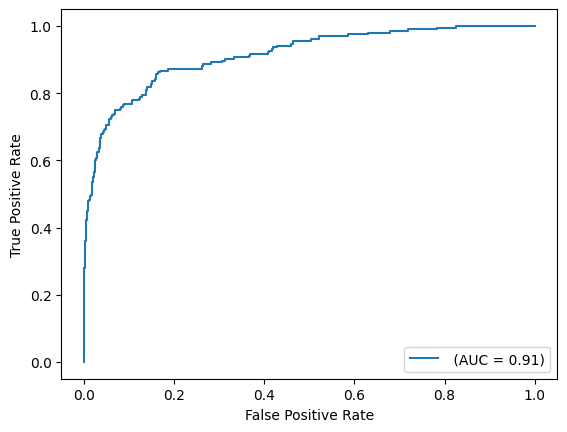

In [172]:
print(              blob_path + run_prefix + 'filtered_blob_stats_tagged.pkl')
plot_roc_blob_stats(blob_path + run_prefix + 'filtered_blob_stats_tagged.pkl')

##### Heavy atom peak heights
See `vae_metric_heavy_atom_peak_value.ipynb`